## Imports and Dataset Exploration

In [114]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [115]:
class LDA:
    def __init__(self, n=0):
        self.d1 = n

    def fit(self, X, y):
        self.d = len(X[0])
        self.classes = np.unique(y)
        self.no_of_classes = len(self.classes)
        self.split_X = []
        for c in self.classes:
            class_X = []
            for i in range(len(y)):
                if y[i] == c:
                    class_X.append(X[i])
            self.split_X.append(class_X)
        # print("Split X : ", self.split_X)

        # Step-1: Finding Mean Vectors for each class
        self.mean_vectors = []
        for X_class in self.split_X:
            self.mean_vectors.append(np.mean(X_class, axis=0))
        self.mean_vectors = np.array(self.mean_vectors)

        # Step-2: Computing Scatter Matrices
        # Part-A: Within class Scatter Matrix
        self.covariance_matrices = []
        for X_class in self.split_X:
            self.covariance_matrices.append(np.cov(X_class, rowvar=False))
        self.covariance_matrices = np.array(self.covariance_matrices)
        self.Sw = np.zeros((self.d, self.d))
        for i in range(self.no_of_classes):
            self.Sw += (len(self.split_X[i])-1)*self.covariance_matrices[i]
        # Part-B: Between class Scatter Matrix
        self.overall_mean = np.mean(X, axis=0)
        self.Sb = np.zeros((self.d, self.d))
        for i in range(self.no_of_classes):
            mean_vec = self.mean_vectors[i].reshape(self.d, 1)
            ovr_mean = self.overall_mean.reshape(self.d, 1)
            self.Sb += len(self.split_X[i])*(mean_vec - ovr_mean).dot((mean_vec - ovr_mean).T)

        # Step-3: Finding Eigen Values and Vectors
        self.eig_vals, self.eig_vecs = np.linalg.eig(np.linalg.inv(self.Sw).dot(self.Sb))

        # Step-4: Sorting Eigen Values and deciding on d'
        ind = np.argsort(self.eig_vals)[::-1]
        self.sorted_eig_vals = self.eig_vals[ind]
        self.sorted_eig_vecs = self.eig_vecs[ind]
        if self.d1 < 1:
            if self.d1 <= 0:
                self.d1 = 0.99
            self.total_variance = np.sum(self.sorted_eig_vals)
            self.selected_eig_values = []
            cum_variance = 0
            i = 0
            while cum_variance < self.d1 * self.total_variance:
                cum_variance += self.sorted_eig_vals[i]
                self.selected_eig_values.append(self.sorted_eig_vals[i])
                i += 1
            self.selected_eig_values = np.array(self.selected_eig_values)
            self.d1 = len(self.selected_eig_values)
        self.final_eig_vecs = self.sorted_eig_vecs[:, :self.d1]

    def transform(self, X):
        X1 = np.dot(X, self.final_eig_vecs)
        return X1

In [116]:
def euclidean_distance(X_train, X_test):
    all_point_distances = []
    for i in X_test:
        point_distance = []
        for j in X_train:
            dist = np.sqrt(np.sum((j-i)**2))
            # dist = math.sqrt((j[0] - i[0])**2 + (j[1] - i[1])**2)
            point_distance.append(dist)
        all_point_distances.append(point_distance)
    arr = np.array(all_point_distances)
    return arr

In [117]:
def knn_classify(distance_array, y_train, k):
    array_indexes = []
    for point in distance_array:
        nearest_points = np.argsort(point)[:k]
        array_indexes.append(nearest_points)
    array_indexes = np.array(array_indexes)

    y_values = []
    for point in array_indexes:
        values = []
        for i in point:
            values.append(y_train[i])
        y_values.append(values)
    y_pred = []
    for point in y_values:
        y_pred.append(max(point, key=point.count))
    y_pred = np.array(y_pred)

    return y_pred

In [118]:
def check_accuracy(y_pred, y_test):
    return np.sum(y_pred == y_test)/len(y_test)

In [119]:
df = pd.read_csv('face.csv')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,4087,4088,4089,4090,4091,4092,4093,4094,4095,target
0,0.309917,0.367769,0.417355,0.442149,0.528926,0.607438,0.657025,0.677686,0.690083,0.685950,...,0.669422,0.652893,0.661157,0.475207,0.132231,0.148760,0.152893,0.161157,0.157025,0
1,0.454545,0.471074,0.512397,0.557851,0.595041,0.640496,0.681818,0.702479,0.710744,0.702479,...,0.157025,0.136364,0.148760,0.152893,0.152893,0.152893,0.152893,0.152893,0.152893,0
2,0.318182,0.400826,0.491736,0.528926,0.586777,0.657025,0.681818,0.685950,0.702479,0.698347,...,0.132231,0.181818,0.136364,0.128099,0.148760,0.144628,0.140496,0.148760,0.152893,0
3,0.198347,0.194215,0.194215,0.194215,0.190083,0.190083,0.243802,0.404959,0.483471,0.516529,...,0.636364,0.657025,0.685950,0.727273,0.743802,0.764463,0.752066,0.752066,0.739669,0
4,0.500000,0.545455,0.582645,0.623967,0.648760,0.690083,0.694215,0.714876,0.723140,0.731405,...,0.161157,0.177686,0.173554,0.177686,0.177686,0.177686,0.177686,0.173554,0.173554,0


In [120]:
df.shape

(400, 4097)

In [121]:
df['target'].nunique()

40

In [122]:
64 * 64

4096

<br><br>

## Image Visualization

In [123]:
def plot_faces(pixels):
    fig, axes = plt.subplots(5, 5, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(np.array(pixels)[i].reshape(64, 64), cmap='gray')
    plt.show()

In [124]:
X = df.drop('target', axis=1)
y = df['target']

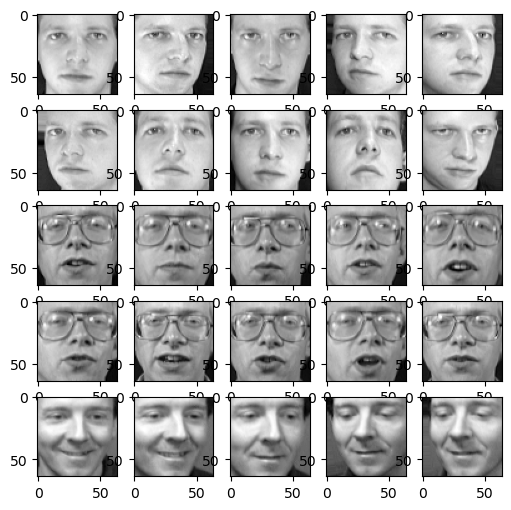

In [125]:
plot_faces(X)

## LDA

In [126]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [127]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [128]:
print(X_train.shape)

(300, 4096)


In [145]:
lda = LDA(105)
lda.fit(X_train, y_train)

In [146]:
X_train_lda = lda.transform(X_train)
X_test_lda = lda.transform(X_test)

## Model Training & Evaluation

In [175]:
eud = euclidean_distance(X_train_lda, X_test_lda)
k = 5
y_pred = knn_classify(eud, y_train, k)
print(f"Actual Output: {y_test}\nPredicted Output: {y_pred}")

Actual Output: [26 22 17 30 16 15 10 20  1 36 31 29 11 24 27 11 34 31  3 39 37 15 28 30
 26  2 34 15  9 21 19 10 15 26 19  4 34 35 35 13 13 21 38  7 17 21 35 31
  6 36 15 22 37 22  7 24  6  5  4 36 10 28  7 31 25 29 14  5 28 38 39 34
 31 34  2  5 17 23  9 25 20 24 32 21 26  7 14  1 32 14  3 36 10 14 28  3
 31  6 25  2]
Predicted Output: [ 9 22  1  1 16 39 17 20 31 12 37 29 11 18  7 11 34 37 29 39  2 30 36 30
 24 12 35  5  9 29 37 10  1  9 36 18 34 35  4 27 13 29 22  9  2 21 34 24
 18 17  5  8 37  6  2 27 36  5  2 36 10 36 26  1  8  4 14 30 35 38 37  1
 22  4 12  5  6  4  9 36 35  2 32 29  4  0 14  4 34 14 17 18  9 14 28  3
  0 18 12  1]


In [176]:
print(f"Accuracy with k={k} : {check_accuracy(y_pred, y_test)*100}%")

Accuracy with k=5 : 28.999999999999996%
